# improve_data_label_v6.ipynb

v5를 기반으로 **구조(모듈화/책임 분리/실험 관리)** 를 강화한 버전이다, 나.

핵심 변경:
- Dataset에서 **타깃 기반 RMS 스케일 정규화 제거**(centering만)
- Config / Data / Model / Loss / Trainer로 구조화
- 2-stage loss(Masked L1 → Kabsch) + Pairwise distance loss 유지
- early stopping + cosine(warmup 포함) 유지


In [12]:
# ==========================================
# 0) Imports, Device, Config
# ==========================================
import os, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dataclasses import dataclass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

@dataclass
class CFG:
    seed: int = 42
    max_len: int = 256
    min_valid: int = 30

    # model
    n_tokens: int = 5           # PAD=0, A=1,C=2,G=3,U=4
    d_model: int = 256
    nhead: int = 8
    layers: int = 6
    dropout: float = 0.1
    num_preds: int = 5

    # train
    batch: int = 16
    epochs: int = 60
    warmup_epochs: int = 5
    lr: float = 3e-5
    wd: float = 1e-2
    grad_clip: float = 1.0
    num_workers: int = 0

    # loss
    dist_w: float = 0.05

    # early stop
    patience: int = 7
    ckpt_path: str = "best_structured_v6.pt"

cfg = CFG()

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all(cfg.seed)


device: cuda


In [13]:
# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")

train_labels = pd.read_csv("train_labels.csv")
val_labels   = pd.read_csv("validation_labels.csv")

print("train_seq:", train_seq.shape, "val_seq:", val_seq.shape)
print("train_labels:", train_labels.shape, "val_labels:", val_labels.shape)


C:\Users\tkdwl\AppData\Local\Temp\ipykernel_9648\648990858.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv("train_labels.csv")


train_seq: (5716, 8) val_seq: (28, 8)
train_labels: (7794971, 8) val_labels: (9762, 126)


In [14]:
# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_sequence(seq: str):
    # unknown -> 0 (PAD)
    return [mapping.get(ch, 0) for ch in seq]

train_seq['tokens'] = train_seq['sequence'].astype(str).apply(tokenize_sequence)
val_seq['tokens']   = val_seq['sequence'].astype(str).apply(tokenize_sequence)

print(train_seq[['target_id','sequence']].head())


  target_id                                           sequence
0      4TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
1      6TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
2      1TRA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
3      1TN2  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
4      1TN1  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...


In [4]:
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e17

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())

train_coords: (5716, 3)
val_coords  : (28, 3)
train_coords NaN/Inf: 0
val_coords   NaN/Inf: 0


In [5]:
# ==========================================
# 4) Build unified dataframe: sequences + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_seq['target_id'] = all_seq['target_id'].astype(str).str.strip()
all_coords['target_id'] = all_coords['target_id'].astype(str).str.strip()

all_df = all_seq.merge(all_coords, on='target_id', how='inner')

# keep only rows that have at least a few valid coordinates
def count_valid(m): 
    m = np.asarray(m, dtype=np.float32)
    return float(m.sum())

all_df['n_valid'] = all_df['coord_mask'].apply(count_valid)
all_df = all_df[all_df['n_valid'] >= cfg.min_valid].reset_index(drop=True)

print("all_df:", all_df.shape)
print(all_df[['target_id','n_valid']].head())


all_df: (4750, 12)
  target_id  n_valid
0      4TNA     76.0
1      6TNA     76.0
2      1TRA     76.0
3      1TN2     76.0
4      1TN1     76.0


In [6]:
# ==========================================
# 5) Dataset (centering only; NO target-based RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, tokens_list, coords_list, mask_list, max_len=256, center_only=True):
        self.tokens_list = tokens_list
        self.coords_list = coords_list
        self.mask_list = mask_list
        self.max_len = max_len
        self.center_only = center_only

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = np.asarray(self.tokens_list[idx], dtype=np.int64)
        coords = np.asarray(self.coords_list[idx], dtype=np.float32)
        mask   = np.asarray(self.mask_list[idx], dtype=np.float32)

        L = min(len(tokens), len(coords), len(mask), self.max_len)
        tokens = tokens[:L]
        coords = coords[:L]
        mask   = mask[:L]

        valid = mask.astype(bool)
        if self.center_only and valid.sum() > 0:
            center = coords[valid].mean(axis=0, keepdims=True)
            coords = coords - center

        tokens_p = np.zeros(self.max_len, dtype=np.int64);  tokens_p[:L] = tokens
        coords_p = np.zeros((self.max_len, 3), dtype=np.float32); coords_p[:L] = coords
        mask_p   = np.zeros(self.max_len, dtype=np.float32); mask_p[:L] = mask

        return torch.tensor(tokens_p), torch.tensor(coords_p), torch.tensor(mask_p)

def filter_batch(tokens, target, mask, min_valid):
    # drop samples with too few valid coords (training stability)
    keep = (mask.sum(dim=1) >= min_valid)
    if keep.sum() < 2:
        return None
    return tokens[keep], target[keep], mask[keep]


In [7]:
# ==========================================
# 6) Train/Holdout split + DataLoader
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=cfg.seed)

train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_ds = RNADataset(train_df['tokens'].tolist(),
                      train_df['coordinates'].tolist(),
                      train_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

hold_ds  = RNADataset(hold_df['tokens'].tolist(),
                      hold_df['coordinates'].tolist(),
                      hold_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

train_loader = DataLoader(train_ds, batch_size=cfg.batch, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
hold_loader  = DataLoader(hold_ds, batch_size=cfg.batch, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print("train batches:", len(train_loader), "hold batches:", len(hold_loader))


train batches: 268 hold batches: 30


In [8]:
# ==========================================
# 7) Losses (Masked L1, Kabsch RMSD, Pairwise Distance MSE) + Composer
# ==========================================
def masked_l1_loss(preds, target, mask):
    # preds: (B,K,T,3)  target: (B,T,3)  mask: (B,T)
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    losses = []
    for k in range(K):
        pk = preds[:, k]
        diff = (pk - target).abs() * m
        denom = m.sum(dim=(1,2)).clamp_min(1.0)
        l1 = diff.sum(dim=(1,2)) / denom
        losses.append(l1)
    losses = torch.stack(losses, dim=1)  # (B,K)
    return losses.min(dim=1).values.mean()

def kabsch_align(P, Q, mask):
    # P,Q: (B,T,3), mask: (B,T)
    mask_exp = mask.unsqueeze(-1)  # (B,T,1)
    mask_sum = mask_exp.sum(dim=1, keepdim=True).clamp_min(1e-8)

    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum

    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    H = torch.matmul(P_c.transpose(1,2), Q_c)  # (B,3,3)
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(1,2)

    det = torch.det(torch.matmul(V, U.transpose(1,2)))
    sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

    E = torch.eye(3, device=P.device, dtype=P.dtype).unsqueeze(0).repeat(P.shape[0],1,1)
    E[:,2,2] = sign

    R = torch.matmul(torch.matmul(V, E), U.transpose(1,2))  # (B,3,3)
    P_aligned = torch.matmul(P_c, R.transpose(1,2)) + Q_mean
    return P_aligned * mask_exp

def kabsch_rmsd_loss(preds, target, mask):
    B, K, T, _ = preds.shape
    losses = []
    for k in range(K):
        pk = preds[:, k]
        pk_aligned = kabsch_align(pk, target, mask)
        diff_sq = (pk_aligned - target) ** 2
        sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1,2))
        n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
        rmsd = torch.sqrt(sum_sq / n_valid + 1e-8)
        losses.append(rmsd)
    losses = torch.stack(losses, dim=1)
    return losses.min(dim=1).values.mean()

def pairwise_distance_loss_full(preds, target, mask):
    # O(T^2): keep identical to v5 behavior
    B, K, T, _ = preds.shape
    m2 = mask.unsqueeze(1) * mask.unsqueeze(2)  # (B,T,T)
    denom = m2.sum(dim=(1,2)).clamp_min(1.0)

    d_true = torch.cdist(target, target)  # (B,T,T)
    losses = []
    for k in range(K):
        pk = preds[:, k]
        d_pred = torch.cdist(pk, pk)
        diff = (d_pred - d_true) ** 2 * m2
        losses.append(diff.sum(dim=(1,2)) / denom)
    losses = torch.stack(losses, dim=1)
    return losses.min(dim=1).values.mean()

class LossComposer(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg

    def forward(self, preds, target, mask, epoch: int):
        if epoch < self.cfg.warmup_epochs:
            return masked_l1_loss(preds, target, mask), "MASKED_L1"
        main = kabsch_rmsd_loss(preds, target, mask)
        dist = pairwise_distance_loss_full(preds, target, mask)
        return main + self.cfg.dist_w * dist, "KABSCH+DIST"


In [9]:
# ==========================================
# 8) Model (Backbone + Head)
# ==========================================
class PositionalEncodingLearned(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        nn.init.normal_(self.pe.weight, mean=0.0, std=0.02)

    def forward(self, x):
        # x: (B,T,D)
        T = x.size(1)
        pos = torch.arange(T, device=x.device)
        return x + self.pe(pos).unsqueeze(0)

class RNABackbone(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.emb = nn.Embedding(cfg.n_tokens, cfg.d_model, padding_idx=0)
        self.pos = PositionalEncodingLearned(cfg.d_model, max_len=2048)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.nhead,
            dim_feedforward=cfg.d_model * 4,
            dropout=cfg.dropout,
            batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=cfg.layers)

    def forward(self, tokens):
        pad_mask = (tokens == 0)
        x = self.emb(tokens)
        x = self.pos(x)
        x = self.enc(x, src_key_padding_mask=pad_mask)
        return x, pad_mask

class CoordHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.num_preds = cfg.num_preds
        self.proj = nn.Linear(cfg.d_model, 3 * cfg.num_preds)

    def forward(self, h):
        # h: (B,T,D) -> (B,K,T,3)
        B, T, D = h.shape
        out = self.proj(h).view(B, T, self.num_preds, 3).permute(0,2,1,3)
        return out

class RNAModel(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.backbone = RNABackbone(cfg)
        self.head = CoordHead(cfg)

    def forward(self, tokens):
        h, _ = self.backbone(tokens)
        coords = self.head(h)
        return coords

model = RNAModel(cfg).to(device)
print("params:", sum(p.numel() for p in model.parameters())/1e6, "M")


params: 5.267983 M


In [10]:
# ==========================================
# 9) Training (v6: structured trainer + warmup+cosine + early stopping)
# ==========================================
class Trainer:
    def __init__(self, cfg: CFG, model: nn.Module, loss_fn: LossComposer, device):
        self.cfg = cfg
        self.model = model
        self.loss_fn = loss_fn
        self.device = device

        self.opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
        self.scheduler = None
        self.global_step = 0

    def build_scheduler(self, train_steps_per_epoch: int):
        total_steps = self.cfg.epochs * train_steps_per_epoch
        warmup_steps = self.cfg.warmup_epochs * train_steps_per_epoch

        def lr_lambda(step):
            if step < warmup_steps:
                return (step + 1) / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * progress))

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.opt, lr_lambda)

    def run_epoch(self, loader, epoch: int, train: bool):
        self.model.train(train)
        total_loss, steps = 0.0, 0
        stage_name = None

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{self.cfg.epochs} [{'train' if train else 'eval'}]")
        for tokens, target, mask in pbar:
            tokens = tokens.to(self.device)
            target = target.to(self.device)
            mask = mask.to(self.device)

            fb = filter_batch(tokens, target, mask, self.cfg.min_valid)
            if fb is None:
                continue
            tokens, target, mask = fb

            with torch.set_grad_enabled(train):
                preds = self.model(tokens)
                loss, stage_name = self.loss_fn(preds, target, mask, epoch)

                if not torch.isfinite(loss):
                    continue

                if train:
                    self.opt.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.grad_clip)
                    self.opt.step()
                    if self.scheduler is not None:
                        self.scheduler.step()
                    self.global_step += 1

            total_loss += float(loss.item())
            steps += 1
            lr = self.opt.param_groups[0]["lr"]
            pbar.set_postfix({"loss": float(loss.item()), "stage": stage_name, "lr": lr})

        return total_loss / max(1, steps), stage_name

    def fit(self, train_loader, val_loader):
        self.build_scheduler(len(train_loader))
        best = float("inf")
        stale = 0

        for epoch in range(self.cfg.epochs):
            tr, stage = self.run_epoch(train_loader, epoch, train=True)
            va, _ = self.run_epoch(val_loader, epoch, train=False)

            print(f"[Epoch {epoch+1:02d}] stage={stage} train={tr:.6f} val={va:.6f}")

            if va < best - 1e-4:
                best = va
                stale = 0
                torch.save(self.model.state_dict(), self.cfg.ckpt_path)
                print(f"✅ best updated: {best:.6f}")
            else:
                stale += 1
                print(f"⏸ no improvement: {stale}/{self.cfg.patience}")
                if stale >= self.cfg.patience and epoch >= self.cfg.warmup_epochs:
                    print("🛑 early stopping.")
                    break

        self.model.load_state_dict(torch.load(self.cfg.ckpt_path, map_location=self.device))
        print("Best model loaded:", self.cfg.ckpt_path, "best_val=", best)

loss_fn = LossComposer(cfg).to(device)
trainer = Trainer(cfg, model, loss_fn, device)
trainer.fit(train_loader, hold_loader)


Epoch 1/60 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Epoch 1/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 37.21it/s, loss=60.4, stage=MASKED_L1, lr=6.02e-6]


[Epoch 01] stage=MASKED_L1 train=52.523580 val=54.205535
✅ best updated: 54.205535


Epoch 2/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 34.90it/s, loss=60.4, stage=MASKED_L1, lr=1.2e-5]


[Epoch 02] stage=MASKED_L1 train=52.417934 val=54.161875
✅ best updated: 54.161875


Epoch 3/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 36.92it/s, loss=60.4, stage=MASKED_L1, lr=1.8e-5]


[Epoch 03] stage=MASKED_L1 train=52.491801 val=54.154571
✅ best updated: 54.154571


Epoch 4/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 58.35it/s, loss=60.5, stage=MASKED_L1, lr=2.4e-5]


[Epoch 04] stage=MASKED_L1 train=52.401193 val=54.149502
✅ best updated: 54.149502


Epoch 5/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 51.47it/s, loss=60.4, stage=MASKED_L1, lr=3e-5]


[Epoch 05] stage=MASKED_L1 train=52.434449 val=54.142759
✅ best updated: 54.142759


Epoch 6/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 39.41it/s, loss=176, stage=KABSCH+DIST, lr=3e-5] 


[Epoch 06] stage=KABSCH+DIST train=156.553754 val=161.381362
⏸ no improvement: 1/7


Epoch 7/60 [eval]: 100%|██████████| 30/30 [00:05<00:00,  5.73it/s, loss=166, stage=KABSCH+DIST, lr=2.99e-5] 


[Epoch 07] stage=KABSCH+DIST train=142.142511 val=152.739082
⏸ no improvement: 2/7


Epoch 8/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 38.28it/s, loss=157, stage=KABSCH+DIST, lr=2.98e-5] 


[Epoch 08] stage=KABSCH+DIST train=133.273742 val=146.260766
⏸ no improvement: 3/7


Epoch 9/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 38.33it/s, loss=150, stage=KABSCH+DIST, lr=2.96e-5] 


[Epoch 09] stage=KABSCH+DIST train=127.205605 val=140.943715
⏸ no improvement: 4/7


Epoch 10/60 [eval]: 100%|██████████| 30/30 [00:05<00:00,  5.71it/s, loss=145, stage=KABSCH+DIST, lr=2.94e-5] 


[Epoch 10] stage=KABSCH+DIST train=122.881240 val=137.202669
⏸ no improvement: 5/7


Epoch 11/60 [eval]: 100%|██████████| 30/30 [00:00<00:00, 39.74it/s, loss=139, stage=KABSCH+DIST, lr=2.91e-5] 


[Epoch 11] stage=KABSCH+DIST train=119.239018 val=132.113094
⏸ no improvement: 6/7


Epoch 12/60 [eval]: 100%|██████████| 30/30 [00:05<00:00,  5.71it/s, loss=134, stage=KABSCH+DIST, lr=2.88e-5] 


[Epoch 12] stage=KABSCH+DIST train=115.909995 val=127.333350
⏸ no improvement: 7/7
🛑 early stopping.
Best model loaded: best_structured_v6.pt best_val= 54.14275932312012


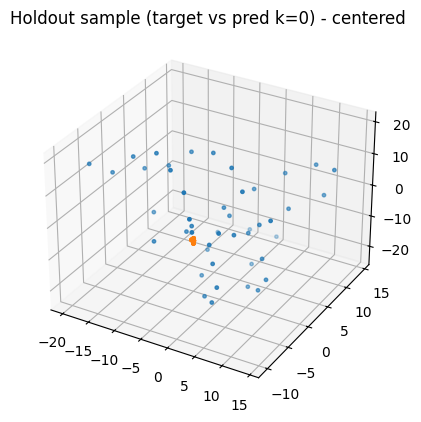

In [11]:
# ==========================================
# 10) Quick visualization on holdout batch (k=0)
# ==========================================
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    preds_b = model(tokens_b)  # (B,K,T,3)
pred0 = preds_b[0,0].detach().cpu().numpy()
tgt0  = tgt_b[0].detach().cpu().numpy()
m0    = m_b[0].detach().cpu().numpy().astype(bool)

pred0 = pred0[m0]
tgt0  = tgt0[m0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(tgt0[:,0], tgt0[:,1], tgt0[:,2], s=6)
ax.scatter(pred0[:,0], pred0[:,1], pred0[:,2], s=6)
ax.set_title("Holdout sample (target vs pred k=0) - centered")
plt.show()
